https://zenodo.org/records/15108715?utm_source=chatgpt.com

This dataset contains real telemetry data collected from the ESA OPS-SAT CubeSat mission, manually annotated for anomaly detection research and ready for training and evaluating ML models. Its structure is organized into two main CSV files:
- segments.csv — Raw Telemetry Segments
    - What it is: A table of raw telemetry fragments (time series) extracted from the OPS-SAT satellite data.
    - Each row represents: one telemetry segment, typically from a single sensor channel over a specific time interval.
    - Contents likely include:
        1. A segment identifier — unique ID for each raw segment.
        2. Timestamp(s) — start and/or sequence of time points for the telemetry readings.
        3. Telemetry values — the actual measured values at each time point (for one channel or multiple channels).
        4. Label/annotation — whether the segment is nominal (normal) or anomalous (depending on manual annotation).
    - Purpose: This is your source of actual signals — raw multivariate or univariate time-series telemetry that can be used to:
        1. Visualize time-series behaviors.
        2. Build signal-based models (e.g., RNNs, CNNs for time series).
        3. Explore anomalies in the original domain.

Key point: Data segments vary in length and sampling frequency — so they’re not harmonized into fixed shapes. That’s why derived features are computed in dataset.csv.

- dataset.csv — Feature-Based Dataset
    - What it is: A tabular dataset where features have been extracted from each telemetry segment in segments.csv.
    - Each row represents: one telemetry segment, same as in segments.csv, but with numeric features instead of raw time-series values.
    - Typical columns include (from the benchmark paper):
        1. Basic statistics: mean, standard deviation, variance, skewness, kurtosis.
        2. Shape descriptors: number of peaks, gap metrics.
        3. Length/duration metrics: number of points, duration in seconds.
        4. Weighted versions of some metrics (e.g., duration-weighted variance).
        5. Label/Target: Most likely there’s a column indicating whether the segment is normal or anomalous — this is what you use for supervised learning.
    - Purpose:
        1. Converts raw telemetry into a fixed-length feature vector per segment.
        2. This makes it suitable for traditional ML models (like random forests, SVMs) and benchmark comparisons — exactly as used in the dataset’s baseline experiments.

# Import librairies

In [73]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import matplotlib.dates as mdates
import seaborn as sns



# Loading data

In [2]:
segments = pd.read_csv("data/raw/segments.csv")
features = pd.read_csv("data/raw/dataset.csv")

print("segment dataset :")
display(segments.head())
print("features dataset :")
display(features.head())

segment dataset :


,channel,timestamp,value,label,sampling,anomaly,segment,train
0,CADC0872,2022-06-01T23:42:54.000Z,-0.000021,anomaly,1,1,1,1
1,CADC0872,2022-06-01T23:42:55.000Z,-0.000021,anomaly,1,1,1,1
2,CADC0872,2022-06-01T23:42:56.000Z,-0.000021,anomaly,1,1,1,1
3,CADC0872,2022-06-01T23:42:57.000Z,-0.000021,anomaly,1,1,1,1
4,CADC0872,2022-06-01T23:42:58.000Z,-0.000021,anomaly,1,1,1,1


features dataset :


,segment,anomaly,train,channel,sampling,duration,len,mean,var,std,...,smooth10_n_peaks,smooth20_n_peaks,diff_peaks,diff2_peaks,diff_var,diff2_var,gaps_squared,len_weighted,var_div_duration,var_div_len
0,1,1,1,CADC0872,1,279,280,8.533143e-07,3.494283e-10,0.000019,...,3,2,4,6,1.271176e-10,2.960666e-10,279,280,1.252431e-12,1.247958e-12
1,2,1,1,CADC0872,1,476,477,-3.639396e-06,6.476485e-10,0.000025,...,1,1,5,8,1.489383e-12,3.004752e-12,476,477,1.360606e-12,1.357754e-12
2,3,1,1,CADC0872,1,594,595,1.170788e-05,5.592877e-10,0.000024,...,2,2,2,3,4.112280e-12,1.029918e-11,594,595,9.415618e-13,9.399794e-13
3,4,1,1,CADC0872,1,271,272,8.486808e-07,5.466024e-10,0.000023,...,2,2,3,6,2.475760e-11,6.240985e-11,271,272,2.016983e-12,2.009568e-12
4,5,0,0,CADC0872,1,256,257,1.058485e-05,5.279023e-10,0.000023,...,1,1,78,87,5.547101e-13,7.035422e-13,256,257,2.062118e-12,2.054094e-12


# EDA - Raw Time Series (segments.csv)

In [3]:
segments.info()
segments.describe()

<class 'pandas.DataFrame'>
RangeIndex: 303493 entries, 0 to 303492
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   channel    303493 non-null  str    
 1   timestamp  303493 non-null  str    
 2   value      303493 non-null  float64
 3   label      303493 non-null  str    
 4   sampling   303493 non-null  int64  
 5   anomaly    303493 non-null  int64  
 6   segment    303493 non-null  int64  
 7   train      303493 non-null  int64  
dtypes: float64(1), int64(4), str(3)
memory usage: 18.5 MB


,value,sampling,anomaly,segment,train
count,303493.000000,303493.000000,303493.000000,303493.000000,303493.000000
mean,0.084209,1.874195,0.330367,773.451539,0.741955
std,0.224150,1.653049,0.470346,587.748209,0.437560
min,-0.000101,1.000000,0.000000,1.000000,0.000000
25%,-0.000005,1.000000,0.000000,283.000000,0.000000
50%,0.000005,1.000000,0.000000,619.000000,1.000000
75%,0.000037,1.000000,1.000000,1031.000000,1.000000
max,1.570800,5.000000,1.000000,2123.000000,1.000000


In [4]:
segments['anomaly'].value_counts(normalize=True)

anomaly
0    0.669633
1    0.330367
Name: proportion, dtype: float64

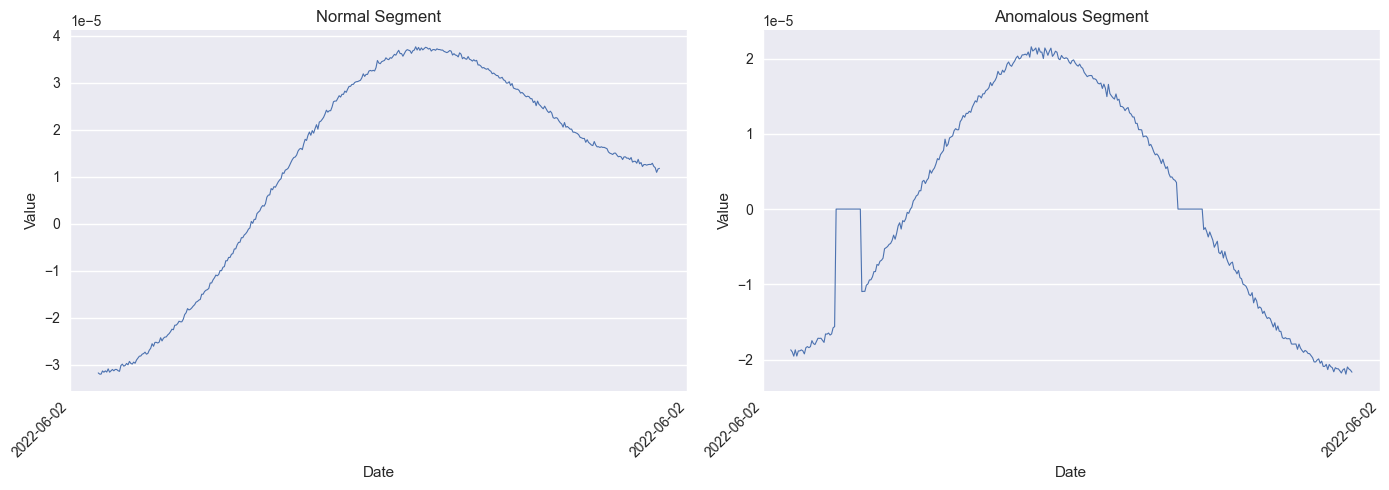

In [ ]:
# Viz to understand what an anomaly looks like
segments['timestamp'] = pd.to_datetime(segments['timestamp'])

normal_segment_id = segments[segments['anomaly'] == 0]['segment'].sample(1).iloc[0]
anomaly_segment_id = segments[segments['anomaly'] == 1]['segment'].sample(1).iloc[0]
normal_segment = segments[segments['segment'] == normal_segment_id]
anomaly_segment = segments[segments['segment'] == anomaly_segment_id]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, segment_df, label in zip(
    axes,
    [normal_segment, anomaly_segment],
    ["Normal Segment", "Anomalous Segment"]
):
    ax.plot(segment_df['timestamp'], segment_df['value'], linewidth=0.8)
    ax.set_title(label)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# EDA - Feature dataset (dataset.csv)

In [68]:
features.info()
features.describe()

<class 'pandas.DataFrame'>
RangeIndex: 2123 entries, 0 to 2122
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   segment           2123 non-null   int64  
 1   anomaly           2123 non-null   int64  
 2   train             2123 non-null   int64  
 3   channel           2123 non-null   str    
 4   sampling          2123 non-null   int64  
 5   duration          2123 non-null   int64  
 6   len               2123 non-null   int64  
 7   mean              2123 non-null   float64
 8   var               2123 non-null   float64
 9   std               2123 non-null   float64
 10  kurtosis          2123 non-null   float64
 11  skew              2123 non-null   float64
 12  n_peaks           2123 non-null   int64  
 13  smooth10_n_peaks  2123 non-null   int64  
 14  smooth20_n_peaks  2123 non-null   int64  
 15  diff_peaks        2123 non-null   int64  
 16  diff2_peaks       2123 non-null   int64  
 17  diff_v

,segment,anomaly,train,sampling,duration,len,mean,var,std,kurtosis,...,smooth10_n_peaks,smooth20_n_peaks,diff_peaks,diff2_peaks,diff_var,diff2_var,gaps_squared,len_weighted,var_div_duration,var_div_len
count,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2.123000e+03,2.123000e+03,2123.000000,2123.000000,...,2123.000000,2123.000000,2123.000000,2123.000000,2.123000e+03,2.123000e+03,2123.000000,2123.000000,2.123000e+03,2.123000e+03
mean,1062.000000,0.204428,0.750824,3.505888,265.613754,142.954781,1.109677e-01,3.065868e-02,0.096226,-1.085494,...,1.110221,1.181818,18.110692,25.286387,9.166359e-04,1.045846e-03,999.228450,267.925106,1.176063e-04,4.361427e-04
std,613.001631,0.403378,0.432638,1.935418,167.158550,152.329786,1.963165e-01,5.491161e-02,0.146319,1.000566,...,0.399227,0.425295,28.991979,32.737797,4.196259e-03,1.127395e-02,1565.349081,166.245528,2.119295e-04,8.845658e-04
min,1.000000,0.000000,0.000000,1.000000,35.000000,8.000000,-3.833030e-05,1.422763e-11,0.000004,-1.858813,...,0.000000,0.000000,0.000000,0.000000,1.962330e-13,3.875356e-13,104.000000,40.000000,2.817267e-14,4.404840e-14
25%,531.500000,0.000000,1.000000,1.000000,175.000000,40.000000,-7.239804e-07,2.960552e-10,0.000017,-1.449123,...,1.000000,1.000000,1.000000,4.000000,3.163852e-12,1.233331e-12,295.000000,175.000000,1.309137e-12,2.809916e-12
50%,1062.000000,0.000000,1.000000,5.000000,225.000000,70.000000,4.515496e-06,6.032890e-10,0.000025,-1.302729,...,1.000000,1.000000,5.000000,14.000000,3.640618e-11,1.095135e-11,500.000000,230.000000,3.786876e-12,1.563517e-11
75%,1592.500000,0.000000,1.000000,5.000000,330.000000,201.000000,2.051710e-01,3.738843e-02,0.193361,-0.996211,...,1.000000,1.000000,21.000000,32.000000,2.982598e-04,1.402282e-04,1200.000000,330.000000,1.886576e-04,4.718514e-04
max,2123.000000,1.000000,1.000000,5.000000,1335.000000,1040.000000,1.118632e+00,2.724801e-01,0.521996,31.201842,...,5.000000,4.000000,240.000000,256.000000,9.987869e-02,3.033986e-01,20750.000000,1340.000000,1.686516e-03,8.031028e-03


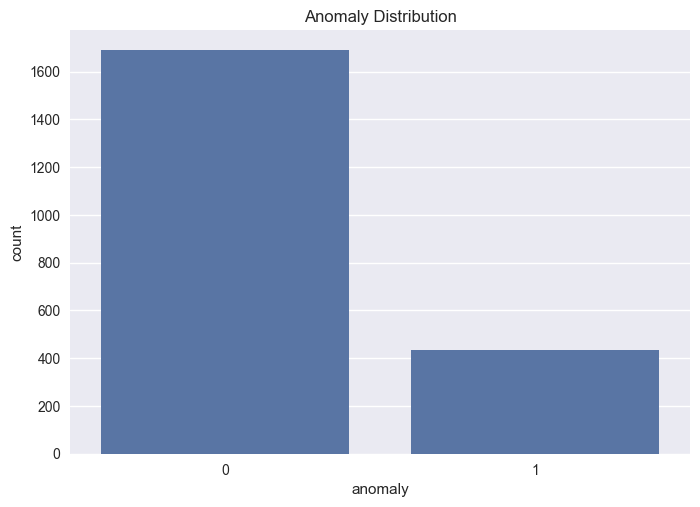

In [74]:
sns.countplot(x="anomaly", data=features)
plt.title("Anomaly Distribution")
plt.show()

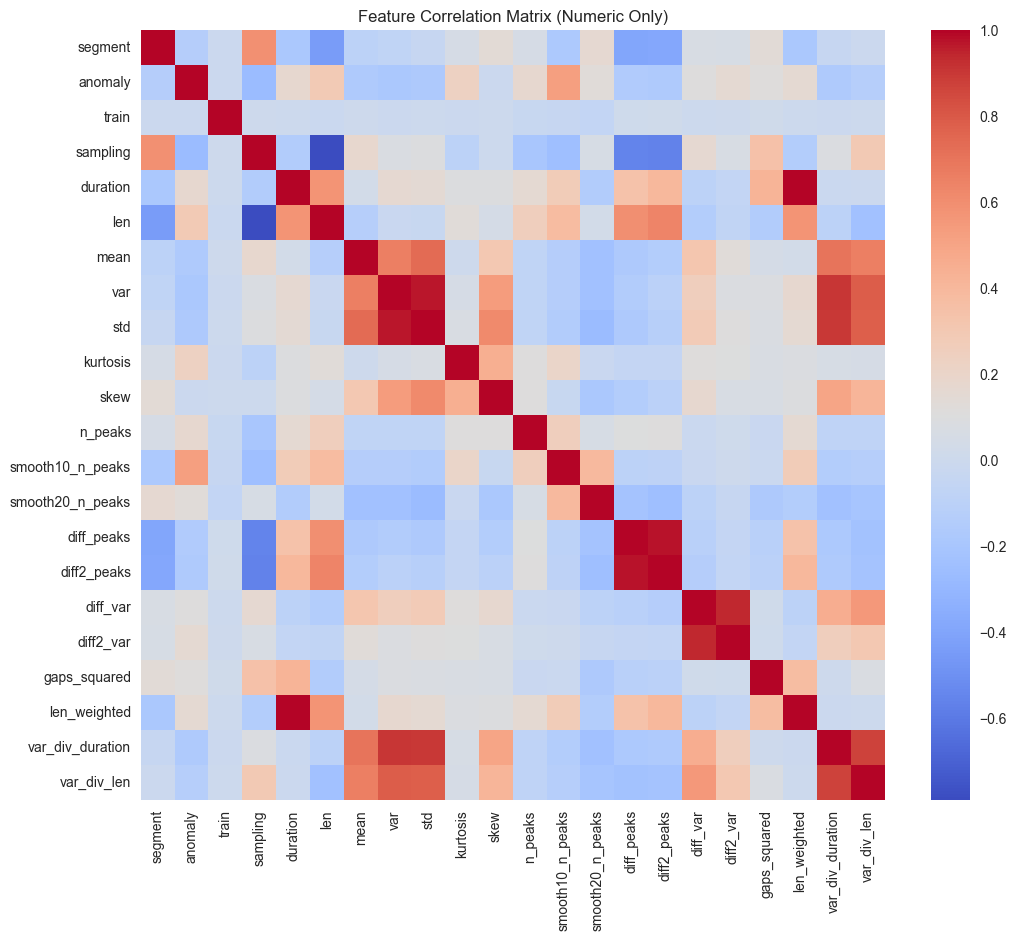

In [79]:
numeric_features = features.select_dtypes(include=[np.number])

plt.figure(figsize=(12,10))
sns.heatmap(numeric_features.corr(), cmap="coolwarm")
plt.title("Feature Correlation Matrix (Numeric Only)")
plt.show()

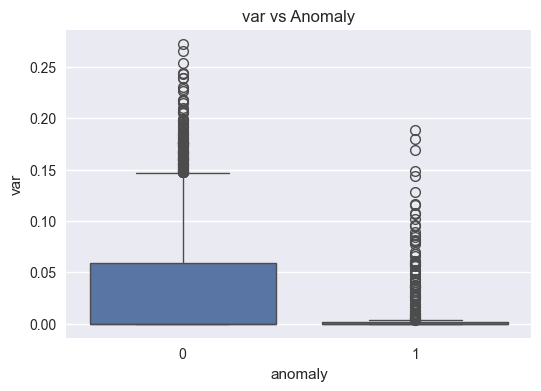

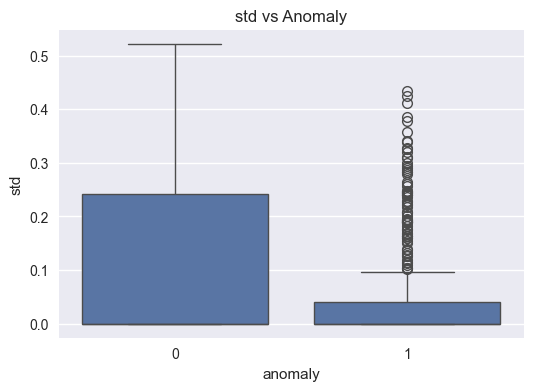

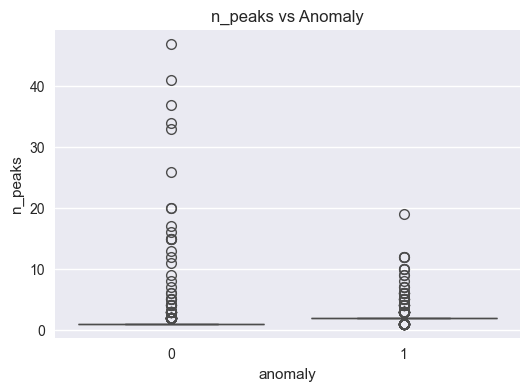

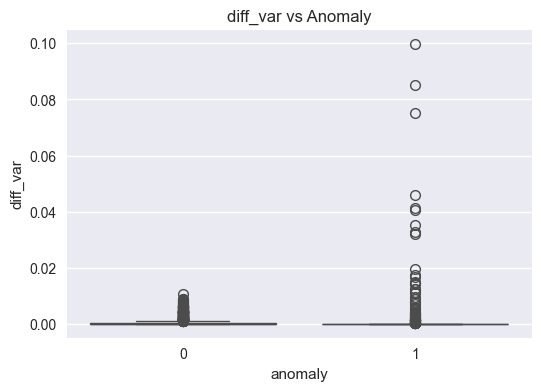

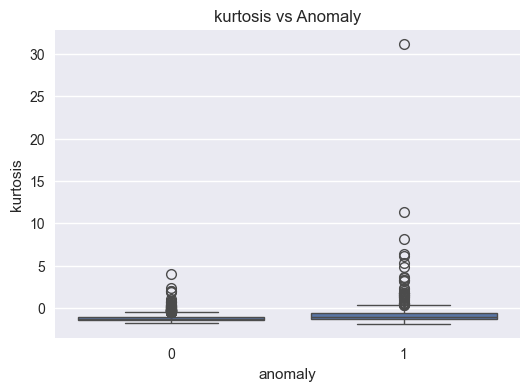

In [82]:
dists = ['var', 'std', 'n_peaks', 'diff_var', 'kurtosis']

for dist in dists:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="anomaly", y=dist, data=features)
    plt.title(f"{dist} vs Anomaly")
    plt.show()